In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt


In [28]:
df = pd.read_csv("/content/amazon_cleaned_final.csv")
print("Shape:", df.shape)
df.head()

Shape: (177008, 30)


/tmp/ipython-input-3135654062.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/amazon_cleaned_final.csv")


,order_id,date,status,fulfilment,sales_channel,ship-service-level,style,sku,category,size,...,b2b,unnamed:_22,stock,year,month,weekday,is_weekend,monthly_expense,month_total_qty,expense_per_unit_month
0,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,men5028,men5028 kr xxl,Unknown,xxl,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.181631,0.657174,0.0
1,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl103,bl103 s,Unknown,s,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.281592,0.657174,0.0
2,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl104,bl104 xl,Unknown,xl,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.764994,0.657174,0.0
3,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl104,bl104 m,Unknown,m,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.670251,0.657174,0.0
4,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl097,bl097 m,Unknown,m,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.303040,0.657174,0.0


In [29]:
# Separate numeric and categorical features

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [30]:
# 1keep only rows where 'amount' exists
if 'amount' not in df.columns:
    raise ValueError("❌ Column 'amount' (target) not found in df.columns. Check the file you're loading.")

df = df[df['amount'].notna()].copy()
print("Shape after dropping rows with missing amount:", df.shape)

Shape after dropping rows with missing amount: (177008, 30)


In [31]:
# 2️⃣ Basic numeric feature engineering

# Sales per item
if set(['amount', 'qty']).issubset(df.columns):
    df['sales_per_item'] = np.where(df['qty'] > 0, df['amount'] / df['qty'], 0)

# Expense-to-sales ratio
if set(['monthly_expense', 'amount']).issubset(df.columns):
    df['expense_sales_ratio'] = np.where(df['amount'] > 0, df['monthly_expense'] / df['amount'], 0)

# Profit margin (amount - expense)
if set(['amount', 'monthly_expense']).issubset(df.columns):
    df['profit_margin'] = df['amount'] - df['monthly_expense']

# Weekend flag (0/1) - au cas où
if 'is_weekend' in df.columns:
    df['weekend_flag'] = df['is_weekend'].fillna(0).astype(int)

# Extra features optionnels
if 'monthly_expense' in df.columns and 'month_total_qty' in df.columns:
    df['expense_per_product'] = df['monthly_expense'] / (df['month_total_qty'] + 1e-5)

if set(['amount', 'qty']).issubset(df.columns):
    df['avg_price_per_item'] = df['amount'] / (df['qty'] + 1e-5)

if set(['profit_margin', 'sales_per_item']).issubset(df.columns):
    df['profit_per_item'] = df['profit_margin'] * df['sales_per_item']

print("✅ Numeric feature engineering done. New shape:", df.shape)

✅ Numeric feature engineering done. New shape: (177008, 37)


In [32]:
# Normalization / Standardization
# Standardization centers data (mean=0, std=1), helpful for regression & ML models

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print("⚖️ Numerical features standardized successfully.")

⚖️ Numerical features standardized successfully.


In [33]:
# 3️⃣ Choose categorical columns to keep (and encode with target encoding)

# Candidate categorical columns
cat_candidates = [
    'category',
    'fulfilment',
    'sales_channel',
    'ship-country',
    'ship_state',
    'ship-city',
    'courier_status',
    'b2b'
]

cat_cols = [c for c in cat_candidates if c in df.columns]

print(f"📌 Categorical columns chosen for encoding: {cat_cols}")

📌 Categorical columns chosen for encoding: ['category', 'fulfilment', 'sales_channel', 'ship-country', 'ship-city', 'courier_status', 'b2b']


In [34]:
# 4️⃣ Target Encoding: replace each category by the mean 'amount' for that category

target = 'amount'

for col in cat_cols:
    df[col] = df[col].fillna("Unknown").astype(str)
    mapping = df.groupby(col)[target].mean()
    df[col + "_te"] = df[col].map(mapping)

# We drop the original text categorical columns, we keep only the columns
df_model = df.drop(columns=cat_cols)
print("Shape after dropping original categorical columns:", df_model.shape)

Shape after dropping original categorical columns: (177008, 37)


In [35]:
# 5️⃣ Remove any remaining non-numeric columns (safety)
non_numeric = df_model.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("⚠️ Dropping remaining non-numeric columns:", non_numeric)
    df_model = df_model.drop(columns=non_numeric)

print("✅ All remaining features are numeric.")
print("df_model shape:", df_model.shape)

⚠️ Dropping remaining non-numeric columns: ['order_id', 'date', 'status', 'ship-service-level', 'style', 'sku', 'size', 'asin', 'currency', 'ship-state', 'promotion-ids', 'unnamed:_22']
✅ All remaining features are numeric.
df_model shape: (177008, 25)


In [36]:
# 6️⃣ Split into X (features) and y (target)

if target not in df_model.columns:
    raise ValueError("❌ Target column 'amount' disappeared. Check previous steps.")

feature_cols = [c for c in df_model.columns if c != target]
X = df_model[feature_cols].copy()
y = df_model[target].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (177008, 24)
y shape: (177008,)


In [37]:
# 7️⃣ RandomForest for feature importance

rf = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n📊 Top 15 most important features:")
print(importances.head(15))



📊 Top 15 most important features:
sales_per_item            4.997818e-01
avg_price_per_item        1.752630e-01
profit_per_item           1.020179e-01
expense_sales_ratio       9.644925e-02
profit_margin             3.747402e-02
qty                       3.572793e-02
expense_per_product       2.670424e-02
monthly_expense           2.657323e-02
month_total_qty           1.936364e-06
fulfilment_te             1.702443e-06
sales_channel_te          1.303882e-06
ship-country_te           1.287941e-06
month                     6.718733e-07
expense_per_unit_month    6.088437e-07
courier_status_te         5.719734e-07
dtype: float64


In [38]:
# 8️⃣ Select top K features (max 30)

top_k = min(30, X.shape[1])
top_features = importances.head(top_k).index.tolist()

X_selected = X[top_features]
df_final = pd.concat([X_selected, y], axis=1)

print(f"\n✅ Selected {X_selected.shape[1]} best features out of {X.shape[1]} total.")
print("Final df_final shape:", df_final.shape)
print("First columns:", df_final.columns[:10].tolist())


✅ Selected 24 best features out of 24 total.
Final df_final shape: (177008, 25)
First columns: ['sales_per_item', 'avg_price_per_item', 'profit_per_item', 'expense_sales_ratio', 'profit_margin', 'qty', 'expense_per_product', 'monthly_expense', 'month_total_qty', 'fulfilment_te']


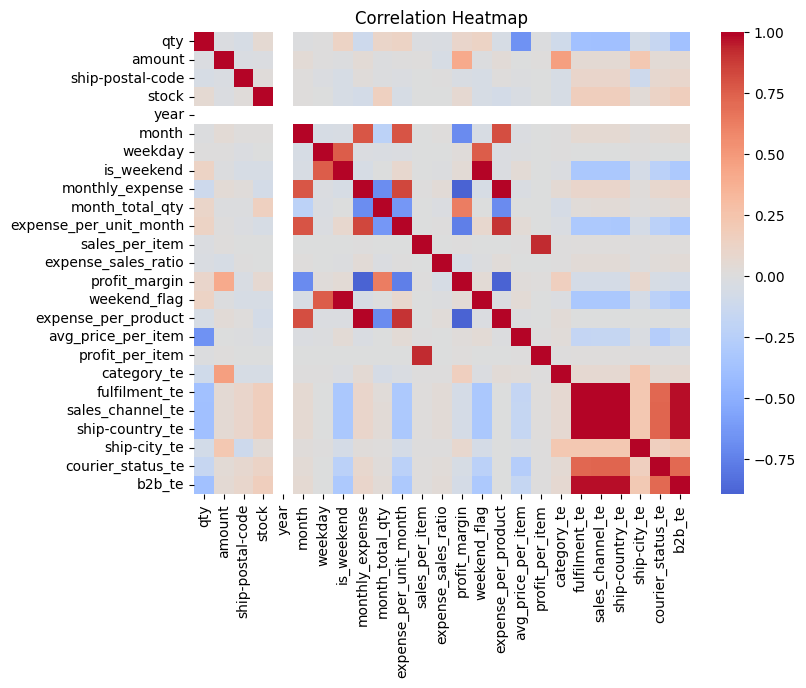

In [45]:
corr_matrix = df_model.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


In [41]:
# keep numeric columns
df_model = df.select_dtypes(include=[np.number])

# print
print(df_model.columns)
print(df_model.shape)

Index(['qty', 'amount', 'ship-postal-code', 'stock', 'year', 'month',
       'weekday', 'is_weekend', 'monthly_expense', 'month_total_qty',
       'expense_per_unit_month', 'sales_per_item', 'expense_sales_ratio',
       'profit_margin', 'weekend_flag', 'expense_per_product',
       'avg_price_per_item', 'profit_per_item', 'category_te', 'fulfilment_te',
       'sales_channel_te', 'ship-country_te', 'ship-city_te',
       'courier_status_te', 'b2b_te'],
      dtype='object')
(177008, 25)


In [42]:
# 9️⃣ Save final dataset for modeling

out_path = "/content/amazon_final_model_dataset.csv"
df_final.to_csv(out_path, index=False)
print(f"\n💾 Final modeling dataset saved as: {out_path}")


💾 Final modeling dataset saved as: /content/amazon_final_model_dataset.csv
